# What do consumers value in a used car?

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 



### Background
Used car dealerships purchase pre-owned vehicles at a price based on the vehicle's features and re-sell the vehicle for a profit.  

### Business Objectives
Understand what factors make a car more or less expensive.

### Business Success Criteria
Identification of factors that influence the price of a car.

### Data Problem Definition
Predict the price of a vehicle based on the factors provided in the dataset. Determine what factors influence this price the most (either increasing its value, or decreasing its value)

### Assumptions
Assuming the provided dataset is ligitimate data obtained via a trusted source.

### Constraints

### Risks and Contingencies

### Terminology

### Costs and Benefits

### Data Mining Goals

### Data Mining Success Criteria 

### Project Plan

### Assessment of Tools and Techniques


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler


In [81]:
df = pd.read_csv('data/vehicles.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [83]:
# Shape of dataset
df.shape

(426880, 18)

id               0.000000
region           0.000000
price            0.000000
year             0.282281
manufacturer     4.133714
model            1.236179
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
size            71.767476
type            21.752717
paint_color     30.501078
state            0.000000
dtype: float64


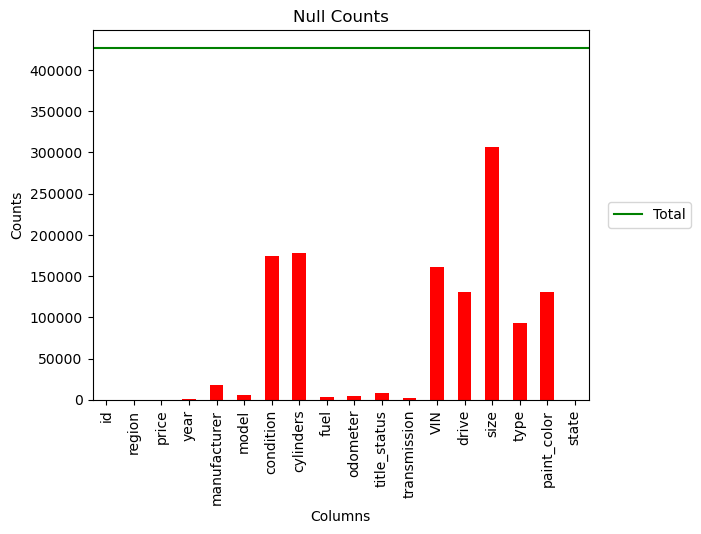

In [4]:
df.isnull().sum().plot(kind='bar', color='r')
plt.axhline(y=df.shape[0], color='g', linestyle='-', label='Total')
plt.title('Null Counts')
plt.xlabel('Columns')
plt.ylabel('Counts')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

print(df.isnull().sum() / df.shape[0] * 100)

The data contains null values. Some columns more than others. Size is missing 71% of its values. Our target variable, price, is present for all rows. WIll be droping column missing a majority of its data as it will not be usefull for modeling.

In [5]:
# Examine numeric data
df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


Price ranges from $0 to $3,736,928,711. That seems a bit ridiculous. Will be triming the dataset of outliers.

Year ranges from 1900 to 2022. It is currently a float.

Price and odometer will need to be normalized. 

When purchasing a car, you want to consider how old the car is. We can compute this with year.

In [6]:
# Examine catagorical data
for column in df.select_dtypes(exclude='number').columns:
    print(f'-----------{column}-----------')
    print(df[[column]].value_counts(normalize=True, dropna=False))
    print('-------------------------------')

-----------region-----------
region                 
columbus                   0.008452
jacksonville               0.008344
spokane / coeur d'alene    0.007000
eugene                     0.006993
fresno / madera            0.006988
                             ...   
meridian                   0.000066
southwest MS               0.000033
kansas city                0.000026
fort smith, AR             0.000021
west virginia (old)        0.000019
Length: 404, dtype: float64
-------------------------------
-----------manufacturer-----------
manufacturer   
ford               0.166288
chevrolet          0.128992
toyota             0.080121
honda              0.049824
nissan             0.044666
jeep               0.044542
ram                0.042968
NaN                0.041337
gmc                0.039320
bmw                0.034434
dodge              0.032110
mercedes-benz      0.027682
hyundai            0.024218
subaru             0.022243
volkswagen         0.021891
kia                0

In [7]:
# Discovery
df.query('fuel == "electric" and manufacturer == "tesla"')[['cylinders']].value_counts(dropna=False)

cylinders  
NaN            632
other           60
4 cylinders      5
6 cylinders      2
dtype: int64

In [8]:
# Find all vehicles that have electric fuel type and also cylinders
df.query('fuel == "electric"').dropna(subset=['cylinders'])

# Having spot checked a few of these on the internet via a VIN check online (https://vpic.nhtsa.dot.gov/decoder/Decoder) 
# and the fuel data does not match the VIN data (1GYS3DKJ9GR322052). This is not an electic vehicle.

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
5890,7312984797,anchorage / mat-su,63995,2017.0,tesla,model s 100d awd,excellent,4 cylinders,electric,32740.0,clean,automatic,5YJSA1E25HF204392,4wd,NaN,sedan,blue,ak
7092,7306965211,anchorage / mat-su,63995,2017.0,tesla,model s 100d awd,excellent,4 cylinders,electric,32740.0,clean,automatic,5YJSA1E25HF204392,4wd,NaN,sedan,blue,ak
7629,7302900513,anchorage / mat-su,54000,2018.0,tesla,s,excellent,other,electric,16000.0,clean,automatic,NaN,4wd,full-size,sedan,white,ak
8391,7315522870,southeast alaska,6999,2012.0,nissan,leaf,good,other,electric,62102.0,clean,automatic,NaN,fwd,compact,hatchback,black,ak
8455,7301681997,southeast alaska,24995,2019.0,nissan,leaf sl,like new,other,electric,5650.0,clean,automatic,1N4AZ1CP6KC307995,fwd,NaN,other,white,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420220,7314438407,madison,36995,2015.0,tesla,model s,good,other,electric,62560.0,clean,automatic,5YJSA1S26FF097869,4wd,NaN,hatchback,blue,wi
420346,7313900574,madison,43470,2018.0,volvo,s90,excellent,4 cylinders,electric,39149.0,clean,automatic,LVYBR0AL5JP048053,4wd,NaN,sedan,white,wi
421083,7308458462,madison,6999,2013.0,nissan,leaf sv,good,other,electric,60038.0,clean,automatic,NaN,fwd,NaN,NaN,NaN,wi
421666,7304202185,madison,9500,2016.0,ford,focus electric hatchback 4d,excellent,other,electric,20000.0,clean,other,NaN,fwd,compact,hatchback,white,wi


I know teslas are 100% electric, however the data is implying that teslas contain an internal combustion engine. This is false.
Additionally, doing some spot VIN checks on the data, I have found the data to be inaccurate.


In [9]:
df.query('fuel == "electric" and manufacturer == "tesla"')[['cylinders']].value_counts(dropna=False)

cylinders  
NaN            632
other           60
4 cylinders      5
6 cylinders      2
dtype: int64



Since the dataset does not come with any definitions, I will infer and assume their meaning and units of measure. 
The data contains state codes from the USA, therfore I will assume this data is using imperial units (Miles) and values is in US Dollars

| Column       | Definition        | Understanding          
|--------------|-------------------|------------------------|
| Region  | Region where the car was purchased/sold   | Values are strings that are not standardized. Values are city names, general areas of the US, some cities contain the state codes, etc. This column will require some cleaning, if not dropping entirely. State will likely be enough for geographical reference     |
| price  | $ (Assuming US Dollars) Value the car was sold for   | This will be our target variable and indicator of value. Price exists for 100% of the rows. Price ranges from $0 to $3,736,928,711. This will require some outlier removal     |
| year  | Year the car was manufactured   | Car manufacture year ranging from 1900 to 2022.     |
| manufacturer  | Manufacturer (Make) of the car   | Values are strings such as ford, gmc, volvo, etc. This should be useful. This data can also be interpreted via the VIN     |
| model  | Model of the car (differs between makes)   | Values are strings such as f-150, camery, 1500, etc. that are not standardized. Values are unique per manufacturer. Similar data can be interpreted from the VIN and will be more standardized.     |
| condition  | Subjective definition of the cars status at the time of selling/purchase   | This data is highly subjective, likely will not be of importance for modeling     |
| cylinders  | Size of engine (Electric cars will not have an engine)   | Engine size is a strong indicator of value, larger engine will likely cost more. Note: Electric vehicles have no engine     |
| fuel  | Type of fuel used in the car   | Fuel type will likely be an important factor for vehicle value. Fuel type impacts the performance and cost of operation.     |
| odometer  | Number of miles (assuming miles) the car has already been driven   | Odometer reading can be used to determine the life left in a vehicle. The higher the odometer, the less life left in the engine. Esitmated vehicle life expectancy differs by manufacture.     |
| title_status  | Status of the legal title for the car   | This can give an idea how the car may have been treated during its ownership     |
| transmission  | Transmissing type of the car (Electric vehicles only have automatic transmission)   | Important indication of vehicle capability     |
| VIN  | Vehicle Identification Number   | Contains encoded data that can be decoded, will likely split this identifier up into its useful pieces. A VIN is unique     |
| drive  | Powertrain of the vehicle   | Important indication of vehicle capability     |
| size  | Size of vehicle, this data is mostly missing and will be removed from analysis    | Understanding of 3     |
| type  | Type of Vehicle   | String value such as truck, SUV, pickup, etc.      |
| paint_color  | Color of vehicle   | Can be a factor for car value. Not many people would like to drive a car with a ungly color.     |
| state  | State the vehicle was purchased/sold in   | Understanding of 3     |
| ...          | ...               | ...                    |


Note: From spot check investigations, data seems to be a bit inaccurate.


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [10]:
df_clean = df[[
    # Commenting out id
    # 'id', 
    'region', 
    'price', 
    'year', 
    'manufacturer', 
    'model', 
    'condition',
    'cylinders', 
    'fuel', 
    'odometer', 
    'title_status', 
    'transmission', 
    'VIN',
    'drive', 
    'size', 
    'type', 
    'paint_color', 
    'state'
    ]].copy()

In [11]:
# 71% of size is missing
df_clean.drop('size', axis=1, inplace=True)

# Drop all rows containing a null value
df_clean.dropna(inplace=True)

# Drop Duplicates
df_clean.drop_duplicates(inplace=True)

# Create age of car
df_clean['year'] = df_clean['year'].astype(int)
df_clean['age'] = 2023 - df_clean['year']

# Price of 0 is pointless to consider
df_clean = df_clean[df_clean['price'] != 0]


In [12]:
df_labeled = df_clean.copy()

for column in df_labeled.select_dtypes(exclude='number'):
    df_labeled[column] = LabelEncoder().fit_transform(df_labeled[column])

df_labeled

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state,age
32,16,27990,2012,14,5059,2,6,2,68696.0,0,2,9638,0,8,0,1,11
33,16,34590,2016,7,5124,2,5,2,29499.0,0,2,8527,0,8,9,1,7
35,16,29990,2016,7,1561,2,5,2,17302.0,0,2,8192,0,8,8,1,7
36,16,38590,2011,7,1666,2,6,2,30237.0,0,2,6732,2,7,8,1,12
38,16,32990,2017,20,6110,2,5,2,30041.0,0,2,833,0,7,9,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426859,391,48590,2020,6,6281,2,5,2,7701.0,0,2,10014,1,7,0,50,3
426860,391,39990,2017,18,4529,2,6,2,41664.0,0,0,24464,0,7,0,50,6
426866,391,32990,2016,18,4529,2,6,2,55612.0,0,0,24491,2,7,0,50,7
426874,391,33590,2018,23,3293,2,5,2,30814.0,0,0,25591,2,9,10,50,5


In [13]:
df_labeled.describe()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state,age
count,51527.000000,51527.000000,51527.000000,51527.000000,51527.000000,51527.000000,51527.000000,51527.000000,5.152700e+04,51527.000000,51527.000000,51527.000000,51527.000000,51527.000000,51527.000000,51527.000000,51527.000000
mean,196.570303,20472.299125,2012.268558,18.336134,3254.771382,1.242611,4.704543,1.959167,8.955432e+04,0.106624,0.499874,13977.513517,0.795583,6.195276,5.675510,23.403206,10.731442
std,117.745756,13717.801582,6.842430,10.917410,1832.654403,1.088700,1.260349,0.594390,1.004132e+05,0.657990,0.841235,8730.287534,0.807669,3.976704,4.095307,14.899062,6.842430
min,0.000000,1.000000,1905.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,87.000000,8990.000000,2010.000000,10.000000,1665.000000,0.000000,3.000000,2.000000,3.569750e+04,0.000000,0.000000,6387.500000,0.000000,3.000000,1.000000,9.000000,6.000000
50%,199.000000,17500.000000,2014.000000,14.000000,3235.000000,2.000000,5.000000,2.000000,8.330900e+04,0.000000,0.000000,13027.000000,1.000000,8.000000,8.000000,22.000000,9.000000
75%,292.000000,29995.000000,2017.000000,27.000000,5033.000000,2.000000,6.000000,2.000000,1.282530e+05,0.000000,1.000000,21666.000000,1.000000,9.000000,10.000000,37.000000,13.000000
max,397.000000,155000.000000,2022.000000,40.000000,6369.000000,5.000000,7.000000,4.000000,9.999999e+06,5.000000,2.000000,30154.000000,2.000000,12.000000,11.000000,50.000000,118.000000


<Axes: >

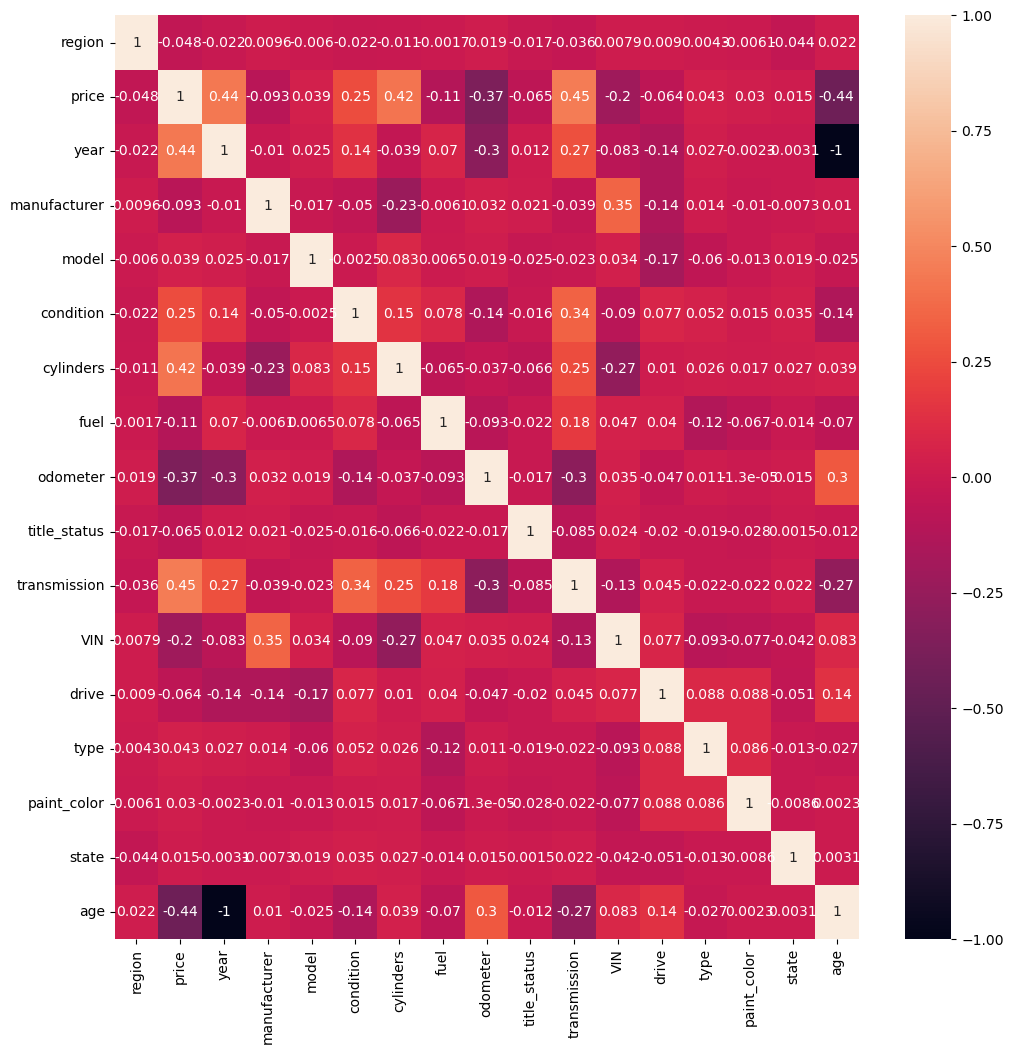

In [14]:
df_labeled.corr()
plt.figure(figsize=(12,12))
sns.heatmap(df_labeled.corr(), annot=True)

array([[<Axes: title={'center': 'region'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'manufacturer'}>],
       [<Axes: title={'center': 'model'}>,
        <Axes: title={'center': 'condition'}>,
        <Axes: title={'center': 'cylinders'}>,
        <Axes: title={'center': 'fuel'}>],
       [<Axes: title={'center': 'odometer'}>,
        <Axes: title={'center': 'title_status'}>,
        <Axes: title={'center': 'transmission'}>,
        <Axes: title={'center': 'VIN'}>],
       [<Axes: title={'center': 'drive'}>,
        <Axes: title={'center': 'type'}>,
        <Axes: title={'center': 'paint_color'}>,
        <Axes: title={'center': 'state'}>],
       [<Axes: title={'center': 'age'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

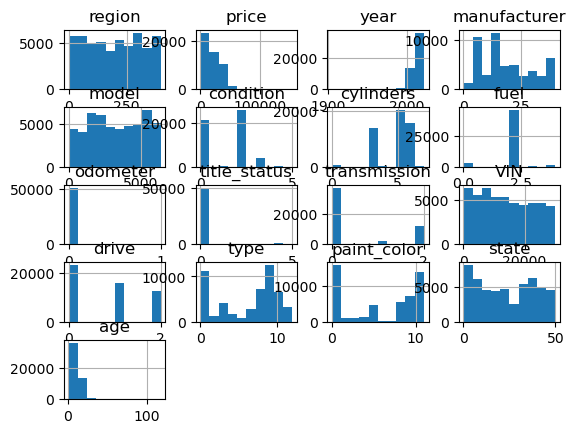

In [15]:
df_labeled.hist()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [31]:
target = 'price'
X = df_labeled.drop(target, axis=1)
y = df_labeled[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)

In [64]:
# Use the average price as a baseline
test_baseline = mean_squared_error(y_test, np.full(len(y_test), y_test.mean()))
train_baseline = mean_squared_error(y_train, np.full(len(y_train), y_train.mean()))
print(f"Baseline Test Mean Squared Error: {test_baseline}")
print(f"Baseline Train Mean Squared Error: {train_baseline}")

Baseline Test Mean Squared Error: 195370417.38849205
Baseline Train Mean Squared Error: 185066750.53091338


Mean Squared Error: 94256793.84335244
['fuel', 'transmission', 'cylinders', 'condition', 'title_status']


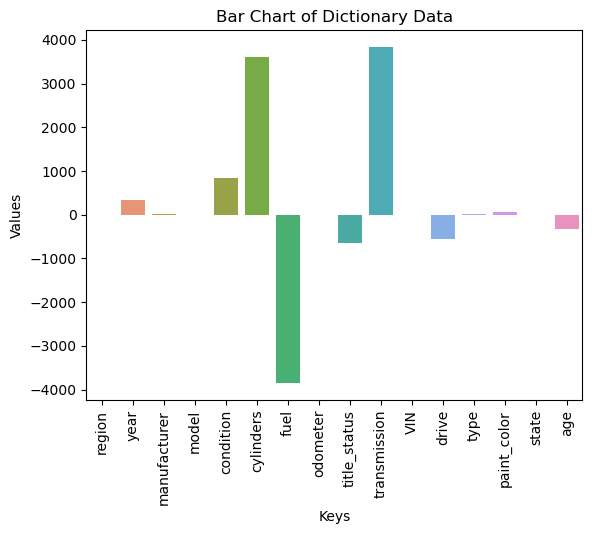

In [56]:
# Simple linear regression
model = LinearRegression()
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

test_mse = mean_squared_error(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
print(f"Test Mean Squared Error: {test_mse}")
print(f"Train Mean Squared Error: {train_mse}")

coefficients = model.coef_
feature_names = X.columns
feature_coefficients = dict(zip(feature_names, coefficients))

# Sort the dictionary by absolute values and pick the top 5
top_5 = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)[:5]

# Extracting just the keys from the top 5
top_5_keys = [key for key, value in top_5]

print(top_5_keys)

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(list(feature_coefficients.items()), columns=['Key', 'Value'])

sns.barplot(x='Key', y='Value', data=df)

# Adding title and labels (optional)
plt.title('Bar Chart of Dictionary Data')
plt.xlabel('Keys')
plt.ylabel('Values')
plt.xticks(rotation=90)

# Show the plot
plt.show()




In [57]:
trainErrors = []
testErrors = []
    
for i in range(1, 5):
    
    pipe = Pipeline([
        ("poly_transform", PolynomialFeatures(degree=i, include_bias=False)),
        ("model_regression", LinearRegression())
    ])

    pipe.fit(X_train, y_train)

    trainErrors.append(mean_squared_error(pipe.predict(X_train), y_train))
    testErrors.append(mean_squared_error(pipe.predict(X_test), y_test))


The Complexity that minimized Test Error was: 2


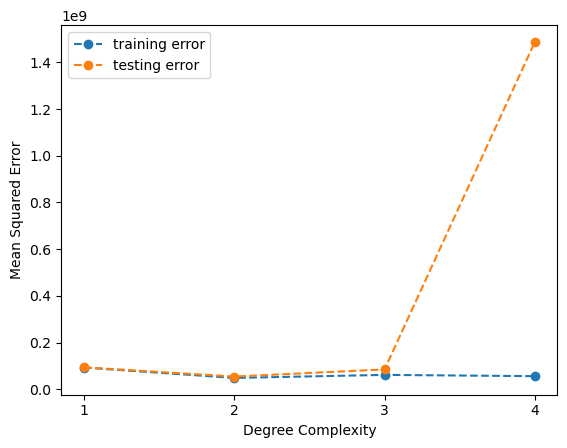

In [59]:
print(f'The Complexity that minimized Test Error was: {testErrors.index(min(testErrors)) + 1}')
plt.plot(range(1, 5), trainErrors, '--o', label = 'training error')
plt.plot(range(1, 5), testErrors, '--o', label = 'testing error')
plt.xticks(range(1, 5), range(1, 5))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend()

Test Mean Squared Error: 85286556.97659367
Train Mean Squared Error: 61984463.2576534
['age^3', 'year transmission age', 'model cylinders^2', 'year drive age', 'VIN drive^2']


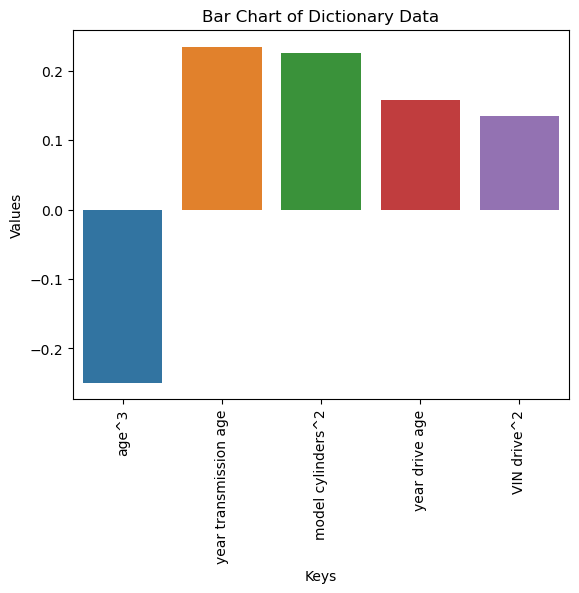

In [67]:
# Polynomial Linear Model of degree 3
poly_pipe = Pipeline([
        ("poly_transform", PolynomialFeatures(degree=3, include_bias=False)),
        ("model_regression", LinearRegression())
    ])

poly_pipe.fit(X_train, y_train)

y_test_pred_poly = poly_pipe.predict(X_test)
y_train_pred_poly = poly_pipe.predict(X_train)

test_mse = mean_squared_error(y_test, y_test_pred_poly)
train_mse = mean_squared_error(y_train, y_train_pred_poly)
print(f"Test Mean Squared Error: {test_mse}")
print(f"Train Mean Squared Error: {train_mse}")

# Get feature names
feature_names = poly_pipe.named_steps['poly_transform'].get_feature_names_out(input_features=X.columns)

# Get coefficients
coefficients = poly_pipe.named_steps['model_regression'].coef_

# Create dictionary of features and coefficients
feature_coefficients = dict(zip(feature_names, coefficients))

# Sort the dictionary by absolute values and pick the top 5
top_5 = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)[:5]

# Extracting just the keys from the top 5
top_5_keys = [key for key, value in top_5]

top_5_map = {}
for key in top_5_keys:
    top_5_map[key] = feature_coefficients[key]

print(top_5_keys)

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(list(top_5_map.items()), columns=['Key', 'Value'])

sns.barplot(x='Key', y='Value', data=df)

# Adding title and labels (optional)
plt.title('Bar Chart of Dictionary Data')
plt.xlabel('Keys')
plt.ylabel('Values')
plt.xticks(rotation=90)

# Show the plot
plt.show()

Best parameters: {'sfs__n_features_to_select': 7}
Best score: -95235079.66680321
CV Scores with best parameters: [-9.59217138e+07 -1.14682810e+08 -8.42590709e+07 -8.65025647e+07
 -9.48092387e+07]
Selected Features and Coefficients:
{'condition': 912.0438214541421, 'cylinders': 4647.398671572803, 'fuel': -2380.1784592107333, 'odometer': -2680.9107140600136, 'transmission': 3005.0157994268175, 'VIN': -520.1081213617101, 'age': -4556.885320541586}


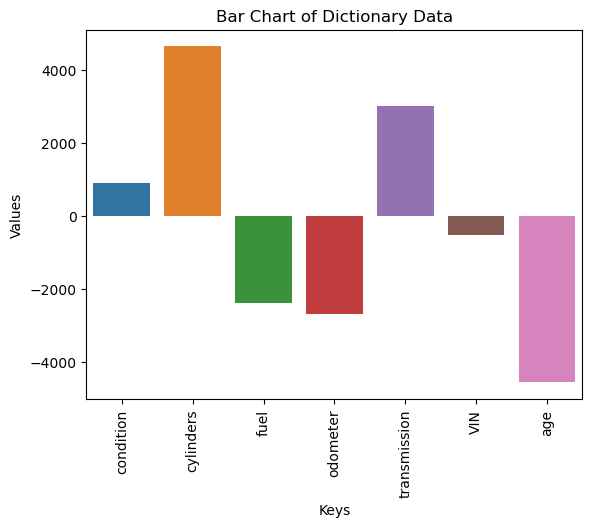

In [71]:
model = LinearRegression()
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sfs', SequentialFeatureSelector(model, direction='forward')),
    ('regressor', model)
])

param_grid = {
    'sfs__n_features_to_select': [3, 5, 7],  # Number of features to select
    # Add other parameters if needed
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
best_pipeline = grid_search.best_estimator_
cv_scores = cross_val_score(best_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
print("CV Scores with best parameters:", cv_scores)

best_sfs = best_pipeline.named_steps['sfs']
best_model = best_pipeline.named_steps['regressor']
selected_features = best_sfs.get_support(indices=True)
feature_names = X.columns[selected_features]
coefficients = best_model.coef_
feature_coefficients = dict(zip(feature_names, coefficients))
print("Selected Features and Coefficients:")
print(feature_coefficients)

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(list(feature_coefficients.items()), columns=['Key', 'Value'])

sns.barplot(x='Key', y='Value', data=df)

# Adding title and labels (optional)
plt.title('Bar Chart of Dictionary Data')
plt.xlabel('Keys')
plt.ylabel('Values')
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [75]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=42))
])
param_grid = {'lasso__alpha': np.logspace(-4, -0.5, 30)}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error: {mse}")
lasso_coefficients = best_model.named_steps['lasso'].coef_
print("Lasso Coefficients:", lasso_coefficients)

feature_coeff_dict = dict(zip(X.columns, lasso_coefficients))
print(feature_coeff_dict)

# coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lasso_coefficients})

# sns.barplot(x='Key', y='Value', data=coeff_df)

# # Adding title and labels (optional)
# plt.title('Bar Chart of Dictionary Data')
# plt.xlabel('Keys')
# plt.ylabel('Values')
# plt.xticks(rotation=90)

# # Show the plot
# plt.show()


/Users/ngratzi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.339e+10, tolerance: 5.365e+08
  model = cd_fast.enet_coordinate_descent(
/Users/ngratzi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.377e+10, tolerance: 5.335e+08
  model = cd_fast.enet_coordinate_descent(
/Users/ngratzi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

Best parameters: {'lasso__alpha': 0.31622776601683794}
Test Mean Squared Error: 94257562.25327992
Lasso Coefficients: [ -363.00497198  5257.82703484   166.32091657    77.53984808
   905.75760378  4550.21326894 -2283.13351996 -2380.39976744
  -428.95235343  3218.80221496  -508.17562509  -456.37723379
    71.48062898   223.89665219   -64.41936646   774.37195266]
{'region': -363.00497197557314, 'year': 5257.827034842356, 'manufacturer': 166.32091656891097, 'model': 77.5398480802104, 'condition': 905.7576037798908, 'cylinders': 4550.213268942114, 'fuel': -2283.133519958168, 'odometer': -2380.399767438357, 'title_status': -428.95235342816363, 'transmission': 3218.802214963097, 'VIN': -508.17562509452296, 'drive': -456.37723378704914, 'type': 71.48062897988869, 'paint_color': 223.8966521900423, 'state': -64.41936646335523, 'age': 774.3719526602847}


/Users/ngratzi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.871e+10, tolerance: 6.675e+08
  model = cd_fast.enet_coordinate_descent(


In [79]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=42))
])
param_grid = {'ridge__alpha': np.logspace(-4, 4, 50)}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error: {mse}")

ridge_coefficients = best_model.named_steps['ridge'].coef_
print("Ridge Coefficients:", ridge_coefficients)

feature_coeff_dict = dict(zip(feature_names, ridge_coefficients))
print(feature_coeff_dict)




Best parameters: {'ridge__alpha': 719.6856730011514}
Test Mean Squared Error: 94436871.6411183
Ridge Coefficients: [ -359.23479945  2223.98795288   148.8515873     83.55409457
   914.97735395  4463.32998028 -2232.25225629 -2350.11331001
  -425.96412075  3180.2296058   -525.83540511  -451.31354546
    76.2778051    221.79640947   -61.01247714 -2223.98795288]
{'condition': -359.2347994494539, 'cylinders': 2223.987952875176, 'fuel': 148.85158729871165, 'odometer': 83.55409456942097, 'transmission': 914.9773539528695, 'VIN': 4463.329980275486, 'age': -2232.2522562947097}


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.